In [1]:
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial import ConvexHull
import pandas as pd
from tensorflow import keras
from sklearn.manifold import TSNE
import os

In [2]:
data = np.load('kinase_data_splits.npz')
X_train = data['X_train']
X_val = data['X_val']
X_test = data['X_test']
print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)

Train shape: (10460, 5523)
Validation shape: (2243, 5523)
Test shape: (2242, 5523)


Model description:
Three Dense layers for the encoder and decoder (1024, 512, 256) 
latent space of 32.

In [3]:
# --- Sampling Layer ---
class Sampling(layers.Layer):
    """
    Sampling layer that implements the reparameterization trick.
    Accepts [z_mean, z_log_var] and returns z = z_mean + exp(0.5*z_log_var)*epsilon.
    """
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def get_config(self):
        config = super().get_config()
        return config

# --- Fully Connected VAE Model ---
class FullyConnectedVAE(Model):
    def __init__(self, input_dim=5523, latent_dim=32, **kwargs):
        """
        Parameters:
          input_dim (int): The size of the flattened input (e.g., 263*21 = 5523).
          latent_dim (int): The dimensionality of the latent space.
        """
        super(FullyConnectedVAE, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        
        # --- Encoder ---
        self.encoder_dense1 = layers.Dense(1024, activation='relu')
        self.encoder_dense2 = layers.Dense(512, activation='relu')
        self.encoder_dense3 = layers.Dense(256, activation='relu')
        self.z_mean_dense = layers.Dense(latent_dim)
        self.z_log_var_dense = layers.Dense(latent_dim)
        self.sampling = Sampling()
        
        # --- Decoder ---
        self.decoder_dense1 = layers.Dense(256, activation='relu')
        self.decoder_dense2 = layers.Dense(512, activation='relu')
        self.decoder_dense3 = layers.Dense(1024, activation='relu')
        self.decoder_output = layers.Dense(input_dim, activation='sigmoid')
    
    def encode(self, inputs, training=False):
        """
        Encodes input data into the latent space.
        Returns: z_mean, z_log_var, z (sampled latent vector).
        """
        x = self.encoder_dense1(inputs)
        x = self.encoder_dense2(x)
        x = self.encoder_dense3(x)
        z_mean = self.z_mean_dense(x)
        z_log_var = self.z_log_var_dense(x)
        z = self.sampling([z_mean, z_log_var])
        return z_mean, z_log_var, z
    
    def decode(self, z, training=False):
        """
        Decodes a latent vector back into the original input space.
        Returns: a reconstructed vector of size input_dim.
        """
        x = self.decoder_dense1(z)
        x = self.decoder_dense2(x)
        x = self.decoder_dense3(x)
        reconstruction = self.decoder_output(x)
        return reconstruction
    
    def call(self, inputs, training=False):
        """
        Executes the model end-to-end, computing the reconstruction and adding the KL divergence loss.
        """
        z_mean, z_log_var, z = self.encode(inputs, training=training)
        reconstruction = self.decode(z, training=training)
        
        # Compute KL divergence: average over the batch.
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )
        self.add_loss(kl_loss)
        
        return reconstruction
    
    def get_config(self):
        config = super(FullyConnectedVAE, self).get_config()
        config.update({
            'input_dim': self.input_dim,
            'latent_dim': self.latent_dim
        })
        return config



In [4]:
if __name__ == "__main__":
    
    # Set VAE parameters
    input_dim = X_train.shape[1]  # e.g., 5523 (i.e., 263*21)
    latent_dim = 32
    
    # Create and compile the VAE model.
    # (Assuming you have a FullyConnectedVAE defined that expects flattened input.)
    vae = FullyConnectedVAE(input_dim=input_dim, latent_dim=latent_dim)
    vae.compile(optimizer='adam', loss='binary_crossentropy')
    
    # Build the model with sample data to initialize weights.
    dummy_input = np.zeros((1, input_dim), dtype=np.float32)
    _ = vae(dummy_input)
    
    # Print model summary.
    vae.summary()
    
    # Ensure data is of float32 type.
    X_train = X_train.astype(np.float32)
    X_val = X_val.astype(np.float32)
    
    # Define callbacks.
    early_stopping = EarlyStopping(
        monitor='val_loss',
        mode='min',
        patience=5,
        restore_best_weights=True
    )
    
    model_checkpoint = ModelCheckpoint(
        'best_standard_vae_model.h5',  # If desired, you can also use the native Keras format, e.g., 'best_vae_model.keras'
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=1
    )
    
    # Train the VAE model using X_train for training and X_val for validation.
    # (The test set should be reserved for final evaluation outside this training cycle.)
    history = vae.fit(
        X_train, X_train,
        epochs=100,
        batch_size=128,
        validation_data=(X_val, X_val),
        callbacks=[early_stopping, model_checkpoint],
        shuffle=True
    )

    # Optionally, after training you can save the model again:
    vae.save('final_standard_vae_model.h5')


Model: "fully_connected_vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (1, 1024)              │     5,656,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (1, 512)               │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (1, 256)               │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (1, 32)                │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (1, 32)                │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sampling (Sampling)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (1, 256)               │         8,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (1, 512)               │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (1, 1024)              │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (1, 5523)              │     5,661,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,655,571 (48.28 MB)

 Trainable params: 12,655,571 (48.28 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.4048
Epoch 1: val_loss improved from inf to 0.13992, saving model to best_standard_vae_model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 16s 143ms/step - loss: 0.4025 - val_loss: 0.1399
Epoch 2/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.1398
Epoch 2: val_loss improved from 0.13992 to 0.13971, saving model to best_standard_vae_model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - loss: 0.1398 - val_loss: 0.1397
Epoch 3/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.1395
Epoch 3: val_loss improved from 0.13971 to 0.13956, saving model to best_standard_vae_model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - loss: 0.1395 - val_loss: 0.1396
Epoch 4/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.1396
Epoch 4: val_loss improved from 0.13956 to 0.13931, saving model to best_standard_vae_model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - loss: 0.1396 - val_loss: 0.1393
Epoch 5/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.1392
Epoch 5: val_loss improved from 0.13931 to 0.13920, saving model to best_standard_vae_model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - loss: 0.1392 - val_loss: 0.1392
Epoch 6/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.1389
Epoch 6: val_loss improved from 0.13920 to 0.13895, saving model to best_standard_vae_model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - loss: 0.1389 - val_loss: 0.1390
Epoch 7/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.1387
Epoch 7: val_loss improved from 0.13895 to 0.13866, saving model to best_standard_vae_model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - loss: 0.1387 - val_loss: 0.1387
Epoch 8/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.1385
Epoch 8: val_loss improved from 0.13866 to 0.13844, saving model to best_standard_vae_model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - loss: 0.1385 - val_loss: 0.1384
Epoch 9/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.1383
Epoch 9: val_loss improved from 0.13844 to 0.13825, saving model to best_standard_vae_model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - loss: 0.1383 - val_loss: 0.1382
Epoch 10/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.1382
Epoch 10: val_loss improved from 0.13825 to 0.13810, saving model to best_standard_vae_model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - loss: 0.1382 - val_loss: 0.1381
Epoch 11/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.1378
Epoch 11: val_loss improved from 0.13810 to 0.13804, saving model to best_standard_vae_model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - loss: 0.1378 - val_loss: 0.1380
Epoch 12/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.1380
Epoch 12: val_loss improved from 0.13804 to 0.13794, saving model to best_standard_vae_model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - loss: 0.1380 - val_loss: 0.1379
Epoch 13/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.1380
Epoch 13: val_loss did not improve from 0.13794
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - loss: 0.1380 - val_loss: 0.1380
Epoch 14/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.1378
Epoch 14: val_loss improved from 0.13794 to 0.13789, saving model to best_standard_vae_model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - loss: 0.1378 - val_loss: 0.1379
Epoch 15/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.1377
Epoch 15: val_loss improved from 0.13789 to 0.13785, saving model to best_standard_vae_model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - loss: 0.1377 - val_loss: 0.1379
Epoch 16/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.1378
Epoch 16: val_loss improved from 0.13785 to 0.13784, saving model to best_standard_vae_model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - loss: 0.1378 - val_loss: 0.1378
Epoch 17/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.1377
Epoch 17: val_loss did not improve from 0.13784
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - loss: 0.1377 - val_loss: 0.1378
Epoch 18/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.1378
Epoch 18: val_loss improved from 0.13784 to 0.13781, saving model to best_standard_vae_model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - loss: 0.1378 - val_loss: 0.1378
Epoch 19/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.1376
Epoch 19: val_loss improved from 0.13781 to 0.13777, saving model to best_standard_vae_model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - loss: 0.1376 - val_loss: 0.1378
Epoch 20/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.1377
Epoch 20: val_loss did not improve from 0.13777
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - loss: 0.1377 - val_loss: 0.1378
Epoch 21/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.1378
Epoch 21: val_loss improved from 0.13777 to 0.13774, saving model to best_standard_vae_model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - loss: 0.1378 - val_loss: 0.1377
Epoch 22/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.1378
Epoch 22: val_loss did not improve from 0.13774
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - loss: 0.1378 - val_loss: 0.1377
Epoch 23/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.1376
Epoch 23: val_loss did not improve from 0.13774
82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - loss: 0.1376 - val_loss: 0.1378
Epoch 24/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.1376
Epoch 24: val_loss did not improve from 0.13774
82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - loss: 0.1376 - val_loss: 0.1378
Epoch 25/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.1377
Epoch 25: val_loss improved from 0.13774 to 0.13772, saving model to best_standard_vae_model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - loss: 0.1377 - val_loss: 0.1377
Epoch 26/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.1377
Epoch 26: val_loss did not improve from 0.13772
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - loss: 0.1377 - val_loss: 0.1377
Epoch 27/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.1375
Epoch 27: val_loss did not improve from 0.13772
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - loss: 0.1375 - val_loss: 0.1378
Epoch 28/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.1377
Epoch 28: val_loss improved from 0.13772 to 0.13771, saving model to best_standard_vae_model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - loss: 0.1377 - val_loss: 0.1377
Epoch 29/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.1377
Epoch 29: val_loss did not improve from 0.13771
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - loss: 0.1377 - val_loss: 0.1377
Epoch 30/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.1376
Epoch 30: val_loss did not improve from 0.13771
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - loss: 0.1376 - val_loss: 0.1378
Epoch 31/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.1377
Epoch 31: val_loss improved from 0.13771 to 0.13768, saving model to best_standard_vae_model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - loss: 0.1377 - val_loss: 0.1377
Epoch 32/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.1375
Epoch 32: val_loss did not improve from 0.13768
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - loss: 0.1375 - val_loss: 0.1377
Epoch 33/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.1377
Epoch 33: val_loss did not improve from 0.13768
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - loss: 0.1377 - val_loss: 0.1377
Epoch 34/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.1377
Epoch 34: val_loss did not improve from 0.13768
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - loss: 0.1377 - val_loss: 0.1377
Epoch 35/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.1377
Epoch 35: val_loss did not improve from 0.13768
82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - loss: 0.1377 - val_loss: 0.1377
Epoch 36/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.1374
Epoch 36: val_loss did not improve from 0.13768
82/82 ━━━━━━━━━━━━━━━━━━━━ 13s 157m

In [6]:
from sklearn.metrics import mean_squared_error
# Global data structure to store evaluation results from multiple models
evaluation_results = []  # Each entry will be a dict with keys: 'model_name', 'version', 'mse'

def evaluate_model_mse(model, X_test):
    """
    Evaluate a given model's reconstruction performance by computing the Mean Squared Error (MSE)
    between the original test data and the model's reconstruction.

    Parameters:
        model: a Keras model that outputs a reconstructed version of its input.
        X_test: numpy array of test data in the correct shape for this model
                (e.g., for a Transformer VAE: (batch, sequence_length, input_dim),
                 for a standard VAE that works on flattened data: (batch, 263*21))

    Returns:
        mse_value: a float, the MSE computed over the entire test set.
    """
    # Get reconstructed outputs from the model.
    predictions = model.predict(X_test)

    # Flatten both the original and the predictions to compute a single MSE value.
    X_test_flat = X_test.flatten()
    predictions_flat = predictions.flatten()

    mse_value = mean_squared_error(X_test_flat, predictions_flat)
    return mse_value

def store_evaluation_result(model_name, version, mse_value, results_data):
    """
    Append a new evaluation result to the results data structure.

    Parameters:
        model_name (str): Identifier for the model.
        version (str): Version of the model.
        mse_value (float): The computed MSE.
        results_data (list): The list to append the result.
    """
    results_data.append({
        'model_name': model_name,
        'version': version,
        'mse': mse_value
    })

def plot_evaluation_results(results_data):
    """
    Plot a bar chart comparing the MSE of different models stored in the results data structure.

    Parameters:
        results_data (list): List of dictionaries, each with keys 'model_name', 'version', 'mse'.
    """
    # Prepare lists for plotting.
    model_labels = [f"{res['model_name']} v{res['version']}" for res in results_data]
    mse_values = [res['mse'] for res in results_data]

    # Create the bar chart.
    plt.figure(figsize=(10, 6))
    plt.bar(model_labels, mse_values, color='skyblue')
    plt.xlabel("Model and Version")
    plt.ylabel("Reconstruction MSE")
    plt.title("Comparison of Reconstruction MSE Across Models")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


In [7]:
# ===== Example Usage =====
# Assume you have a test dataset 'X_test' in the correct shape for a particular model.
# For Transformer VAE: X_test should have shape (batch_size, sequence_length, input_dim) i.e. (-1, 263, 21)
# For a standard (flattened) VAE, X_test should have shape (batch_size, 263*21) i.e. (-1, 5523)

# Example:
mse_modelA = evaluate_model_mse(vae, X_test)
store_evaluation_result("ModelA", "1.0", mse_modelA, evaluation_results)
#
# mse_modelB = evaluate_model_mse(modelB, X_test)
# store_evaluation_result("ModelB", "1.0", mse_modelB, evaluation_results)


71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


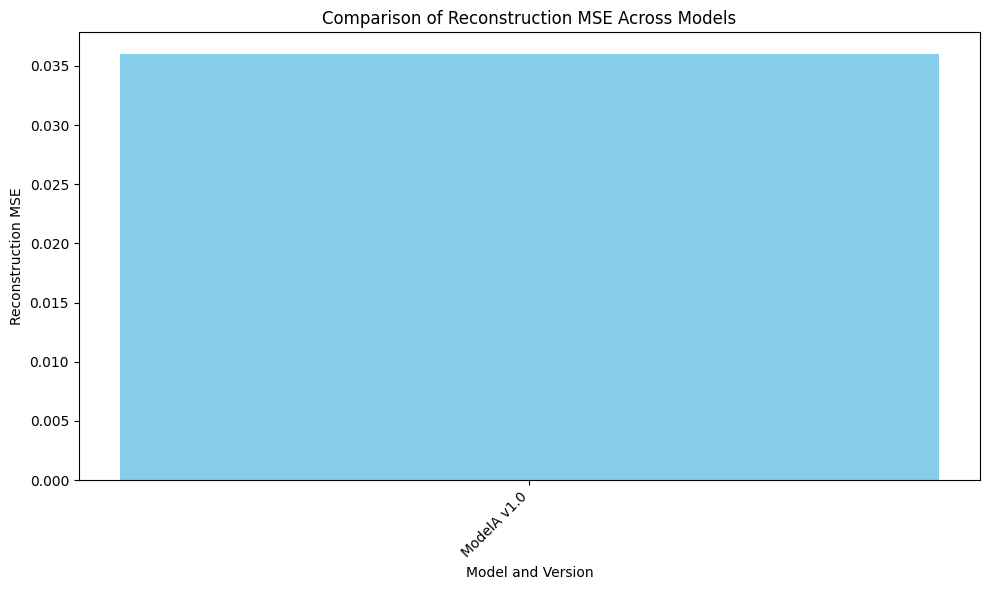

In [8]:
# Then, finally plot:
plot_evaluation_results(evaluation_results)